# System dimensions

In [ ]:
# Measure time of execution
!pip install ipython-autotime
%load_ext autotime

proportion = 1
k = 1

Lx = 31*proportion
Ly = 16*proportion 
Lz = 16*proportion

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.63 s


# Lattice Boltzmann coefficients

In [ ]:
Q = 7       #number of veolcities
W0 = 1.0/4  #weight of each velocity
K = 1       #walls reflection coefficients

C = 0.5     #Wave velocity
C0 = 3*C*C
C1 = 1 + C0*(W0 -1 )

TAU  = 0.5
TAU1 = 1.0/TAU
TAU2 = 1.0 - TAU1

time: 6.2 ms


# Lattice Boltzmann class 

In [ ]:
#import cupy as cp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 


class LatticeBoltzmann:

  def __init__(self): 
    #Creating Vectors
    self.W, self.V = np.zeros(Q, dtype=float), np.zeros([3,Q], dtype=int)
    self.f, self.fnew = np.zeros([Lx, Ly, Lz, Q], dtype=float), np.zeros([Lx, Ly, Lz, Q], dtype=float)

    #loading weights
    self.W[0] = W0;     self.W[1] = self.W[2] = self.W[3] = self.W[4] = self.W[5] = self.W[6] = W0/2.0
    
    #loading vectors
    self.V[0][0] = 0;    self.V[1][0] = 0;     self.V[2][0] = 0;

    self.V[0][1] = 1;    self.V[0][2] = -1;    self.V[0][3] = 0;    self.V[0][4] =  0;    self.V[0][5] = 0;    self.V[0][6] =  0;
    self.V[1][1] = 0;    self.V[1][2] =  0;    self.V[1][3] = 1;    self.V[1][4] = -1;    self.V[1][5] = 0;    self.V[1][6] =  0;
    self.V[2][1] = 0;    self.V[2][2] =  0;    self.V[2][3] = 0;    self.V[2][4] =  0;    self.V[2][5] = 1;    self.V[2][6] = -1;  

  def rho(self, ix, iy, iz, new):
    suma = 0
    for q in range(Q):
      if new: suma += self.fnew[ix][iy][iz][q]
      else:   suma += self.f[ix][iy][iz][q]
    return suma

  def Jx(self, ix, iy, iz, new):
    suma = 0
    for q in range(Q):
      if new: suma += self.fnew[ix][iy][iz][q]*self.V[0][q]
      else:   suma += self.f[ix][iy][iz][q]*self.V[0][q]
    return suma

  def Jy(self, ix, iy, iz, new):
    suma = 0
    for q in range(Q):
      if new: suma += self.fnew[ix][iy][iz][q]*self.V[1][q]
      else:   suma += self.f[ix][iy][iz][q]*self.V[1][q]
    return suma

  def Jz(self, ix, iy, iz, new):
    suma = 0
    for q in range(Q):
      if new: suma += self.fnew[ix][iy][iz][q]*self.V[2][q]
      else:   suma += self.f[ix][iy][iz][q]*self.V[2][q]
    return suma

  def feq(self, rho0, Jx0, Jy0, Jz0, q):
    if q == 0: return rho0*(1-C0)
    else:      return 4*self.W[q]*(C*C*rho0 + (self.V[0][q]*Jx0 + self.V[1][q]*Jy0 + self.V[2][q]*Jz0))

  def Collide(self, flag):
    for ix in range(Lx):
      for iy in range(Ly):
        for iz in range(Lz):
          rho0, Jx0, Jy0, Jz0 = self.rho(ix, iy, iz, False), self.Jx(ix, iy, iz, False), self.Jy(ix, iy, iz, False), self.Jz(ix, iy, iz, False)
          if flag:
            for q in range(Q): self.fnew[ix][iy][iz][q] = TAU2*self.f[ix][iy][iz][q] + TAU1*self.feq(rho0, Jx0, Jy0, Jz0, q)
          else:
            self.fnew[ix][iy][iz][0] = TAU2*self.f[ix][iy][iz][0] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,0)
            self.fnew[ix][iy][iz][3] = TAU2*self.f[ix][iy][iz][3] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,3)
            self.fnew[ix][iy][iz][4] = TAU2*self.f[ix][iy][iz][4] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,4)

            if ix == Lx - 1 or ix == 0:   
              self.fnew[ix][iy][iz][2], self.fnew[ix][iy][iz][1] = k*self.f[ix][iy][iz][1], k*self.f[ix][iy][iz][2]
            else: 
              self.fnew[ix][iy][iz][1] = TAU2*self.f[ix][iy][iz][1] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,1)
              self.fnew[ix][iy][iz][2] = TAU2*self.f[ix][iy][iz][2] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,2)

            if iy == Ly - 1 or iy == 0:   
              self.fnew[ix][iy][iz][3], self.fnew[ix][iy][iz][4] = k*self.f[ix][iy][iz][4], k*self.f[ix][iy][iz][3]
            else: 
              self.fnew[ix][iy][iz][1] = TAU2*self.f[ix][iy][iz][1] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,1)
              self.fnew[ix][iy][iz][2] = TAU2*self.f[ix][iy][iz][2] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,2)

            if iz == Lz - 1 or iz == 0:   
              self.fnew[ix][iy][iz][6], self.fnew[ix][iy][iz][5] = k*self.f[ix][iy][iz][5], k*self.f[ix][iy][iz][6]
            else: 
              self.fnew[ix][iy][iz][1] = TAU2*self.f[ix][iy][iz][1] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,1)
              self.fnew[ix][iy][iz][2] = TAU2*self.f[ix][iy][iz][2] + TAU1*self.feq(rho0,Jx0,Jy0,Jz0,2)
          
  def Advection(self):
    for ix in range(Lx):
      for iy in range(Ly):
        for iz in range(Lz):
          for q in range(Q):
            if 0 <= ix + self.V[0][q] < Lx and 0 <= iy + self.V[1][q] < Ly and 0 <= iz + self.V[2][q] < Lz:
              self.f[ix+self.V[0][q]][iy+self.V[1][q]][iz+self.V[2][q]][q] = self.fnew[ix][iy][iz][q]

  def Inicie(self, rho0, Jx0, Jy0, Jz0):
    for ix in range(Lx):
      for iy in range(Ly):
        for iz in range(Lz):
          for q in range(Q):
            self.f[ix][iy][iz][q] = self.feq(rho0, Jx0, Jy0, Jz0, q)
    
  def Field(self, t):
    lambd = 5; omega = 2*np.pi*C/lambd; A = 10
    ix, iy, iz = int(Lx/2), int(Ly/2), 0
    #if t < 5:
    rho0, Jx0, Jy0, Jz0 = A, self.Jx(ix, iy, iz, False), self.Jy(ix, iy, iz, False), self.Jz(ix, iy, iz, False) #A*np.sin(omega*t)
    for q in range(Q): self.fnew[ix][iy][iz][q] = self.feq(rho0, Jx0, Jy0, Jz0, q)
        
  def ExportData(self, FileName, t):
    Data = []
    for ix in range(Lx):
      for iy in range(Ly):
         #for iz in range(Lz):
          iz = 0
          Data.append([ix, iy, iz, self.rho(ix, iy, iz, False)])
          #Data[0].append(ix) #Data[1].append(iy) #Data[2].append(iz) #Data[3].append(self.rho(ix, iy, iz, False))
    #pd.DataFrame(Data).to_csv(path + FileName + '{}.csv'.format(t), index=False)
    return pd.DataFrame(Data, columns=['x','y','z','rho'])

  def Print(self, vec):
    ix, iy, iz = vec[0], vec[1], vec[2]
    rho0 = self.rho(ix, iy, iz, False)
    return rho0

time: 358 ms


# Plotting and process data functions


In [ ]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def ProcessData(X, Lx):
  Data = []
  [Data.append(list(X[i*Ly:(i+1)*Ly])) for i in range(Lx)]
  return Data

mini, maxi = -10, 10

def Plot(Object, saving):
  df = Object.ExportData('test', t)[['x', 'y', 'rho']]
  X, Y, Z = ProcessData(df['x'], Lx), ProcessData(df['y'], Lx), ProcessData(df['rho'], Lx)  #Len 31
  #'''
  plt.contourf(X, Y, Z, 60, cmap='RdGy' )
  plt.colorbar()
  plt.clim(-10,10)
  plt.axis(aspect='image', vmin=mini, vmax=maxi)
  '''
  levels = np.linspace(mini, maxi, 10)
  fig, ax = plt.subplots(figsize=(6,6))
  cp = plt.contourf(X, Y, Z)
  cf = ax.contourf(X,Y,Z, levels=levels, vmin=mini, vmax=maxi)
  fig.colorbar(cf, ax=ax)
  '''

  plt.pause(1)
  if saving: pass
  else: pass

def Plot3D(Object):
  # 2D-arrays from DataFrame
  df = Object.ExportData('test', t)[['x', 'y', 'rho']]
  x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
  y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))

  """
  x, y via meshgrid for vectorized evaluation of 2 scalar/vector fields 
  over 2-D grids, given one-dimensional coordinate arrays x1, x2,..., xn.
  """

  x2, y2 = np.meshgrid(x1, y1)

  # Interpolate unstructured D-dimensional data.
  z2 = griddata((df['x'], df['y']), df['rho'], (x2, y2), method='cubic')
  # Ready to plot
  fig = plt.figure(figsize=(14, 14))
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(x2, y2, z2, rstride=2, cstride=1, 
                         cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=mini, vmax=maxi)
  ax.set_zlim(-1, 1)

  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

  fig.colorbar(surf, shrink=0.75, aspect=10)
  #plt.title('Meshgrid Created from 3 1D Arrays')

  plt.show()


time: 63.2 ms


# Main program

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


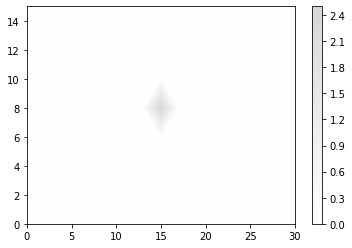

1


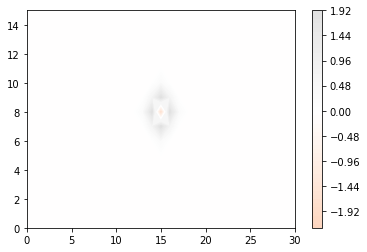

2


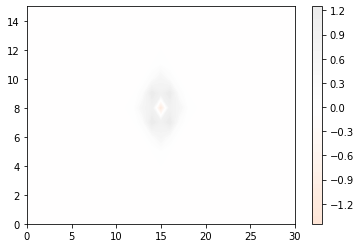

3


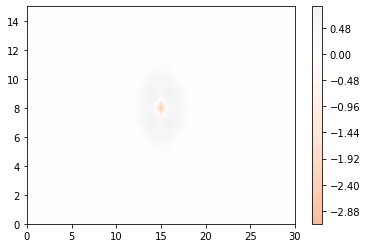

4


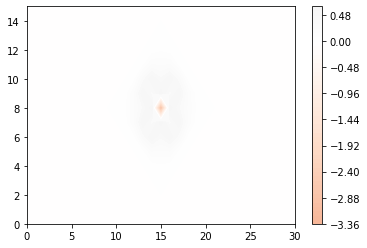

5


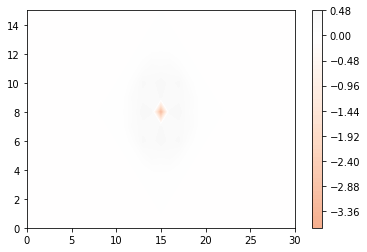

6


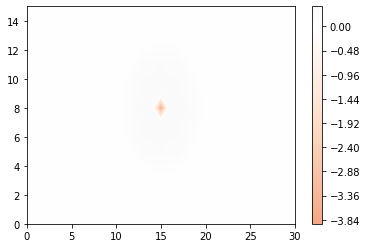

7


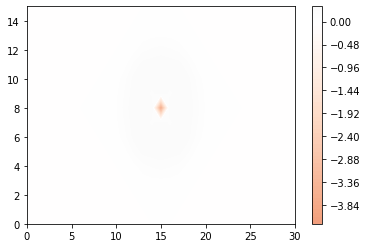

8


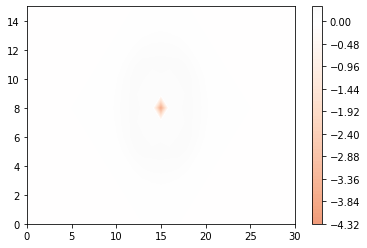

9


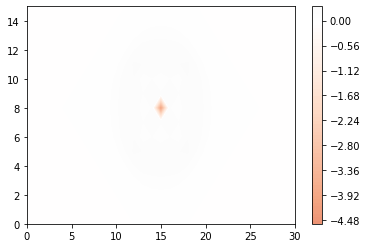

10


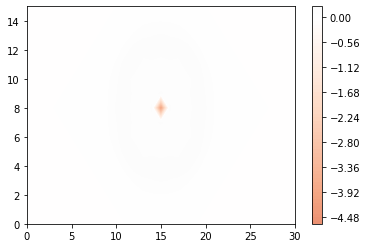

11


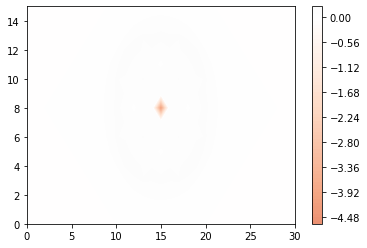

12


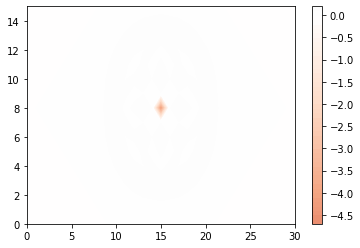

13


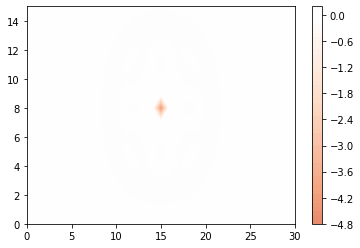

14


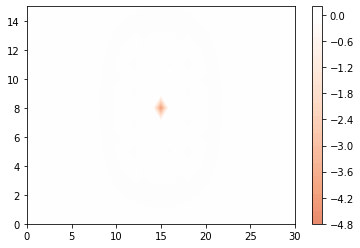

15


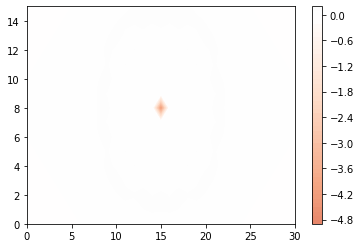

16


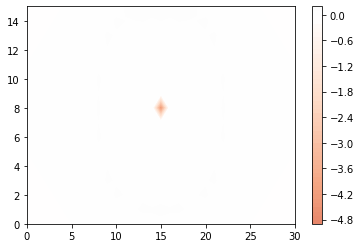

17


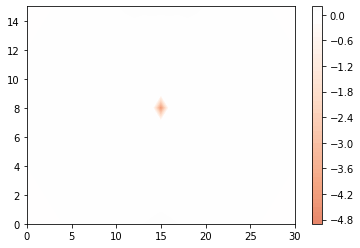

18


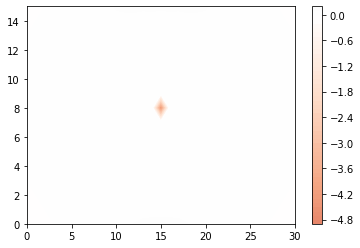

19


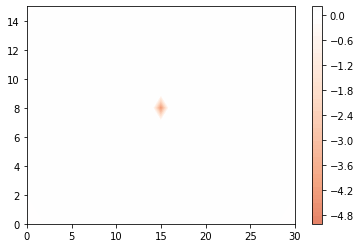

20


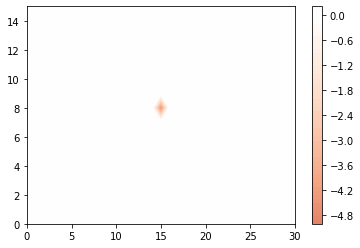

21


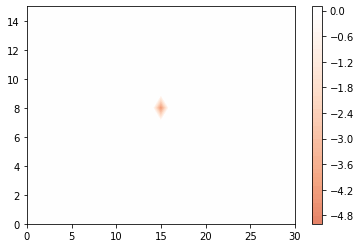

22


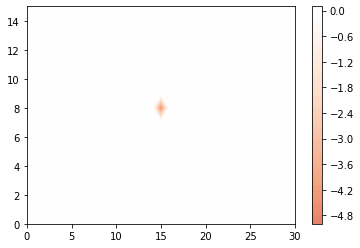

23


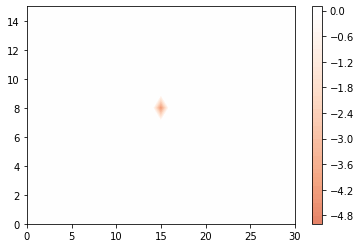

24


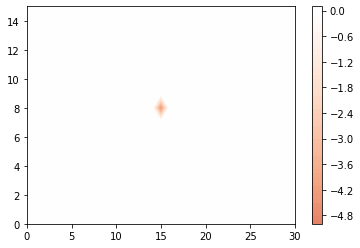

25


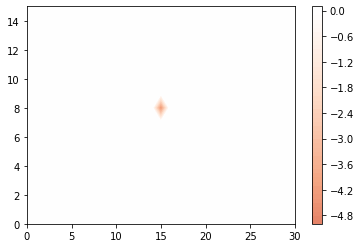

26


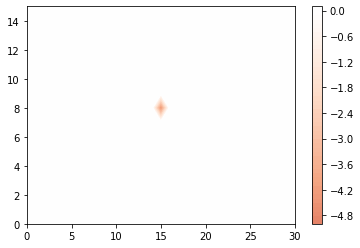

27


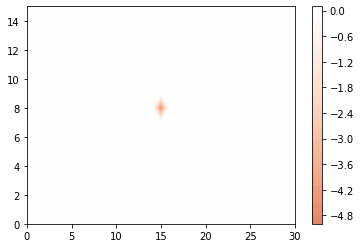

28


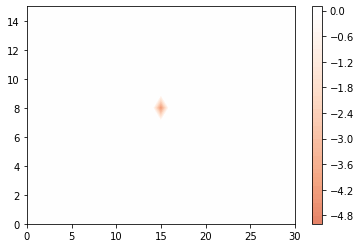

29


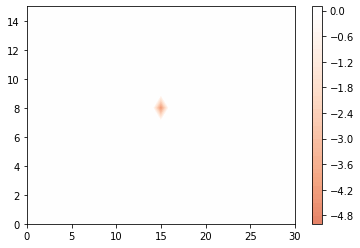

30


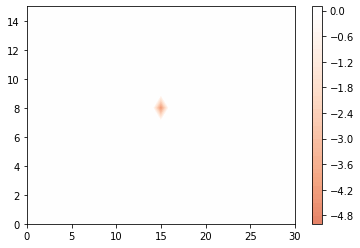

31


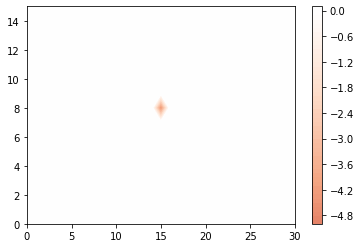

32


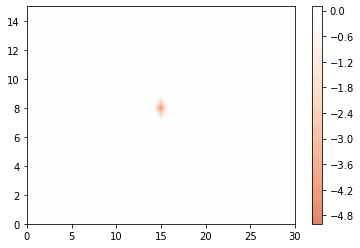

33


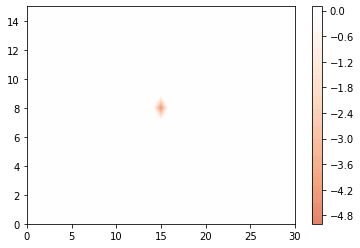

34


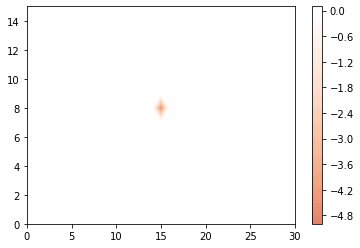

35


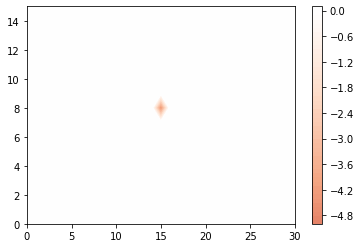

36


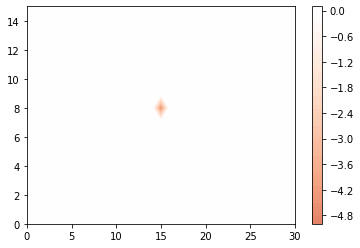

37


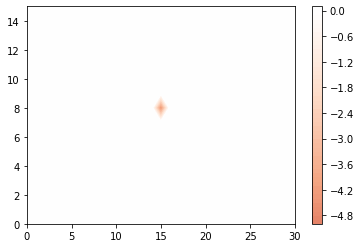

38


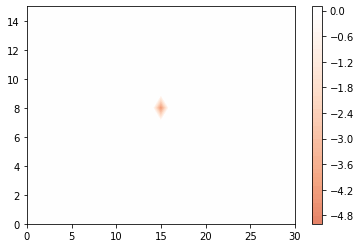

39


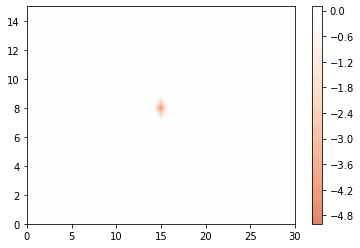

40


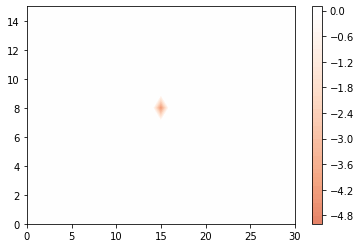

41


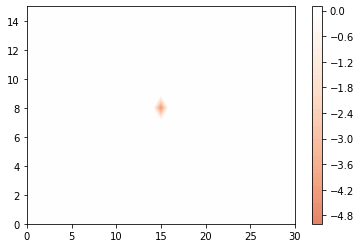

42


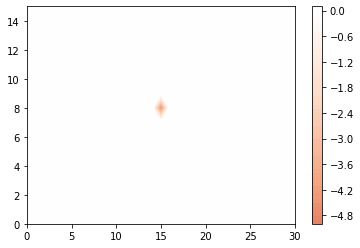

43


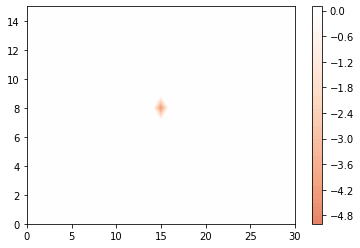

44


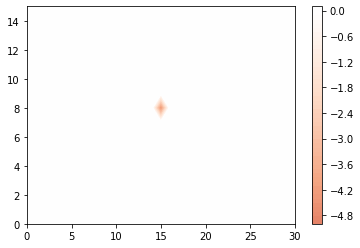

45


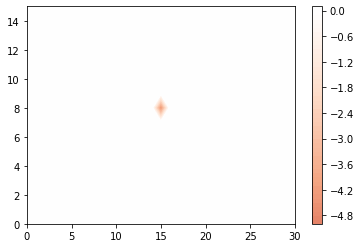

46


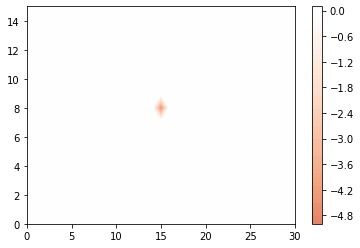

47


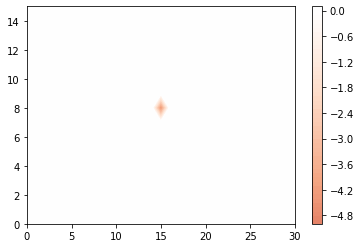

48


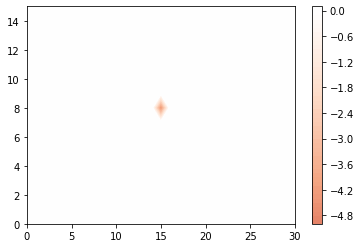

49


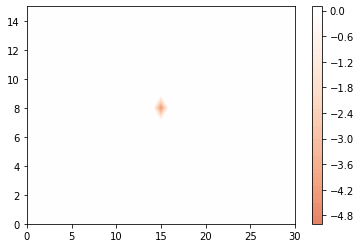

50


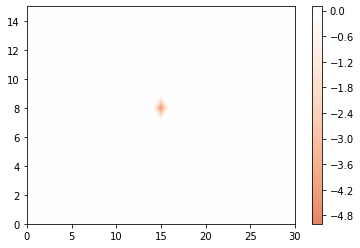

51


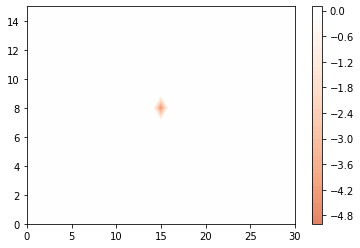

52


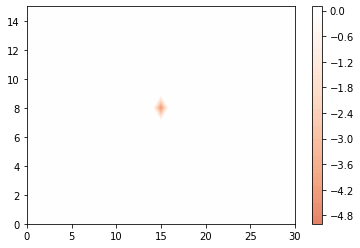

53


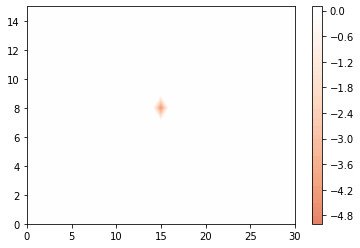

54


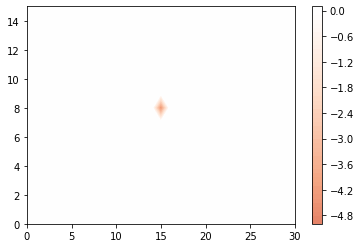

55


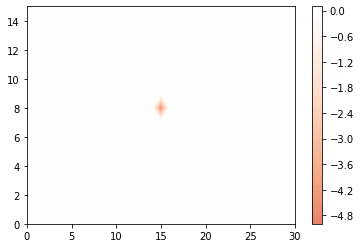

56


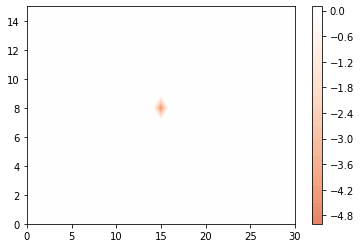

57


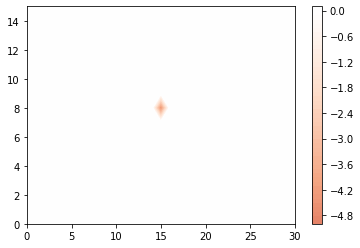

58


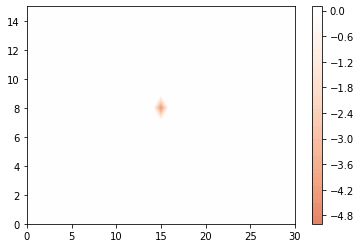

59


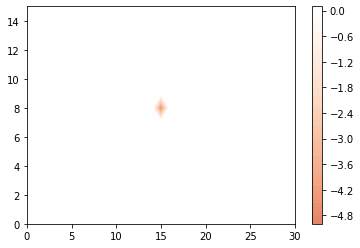

60


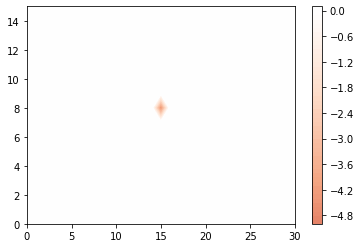

61


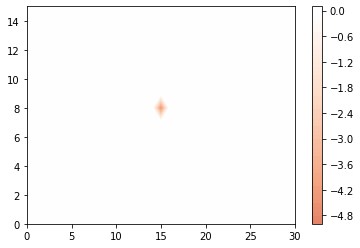

62


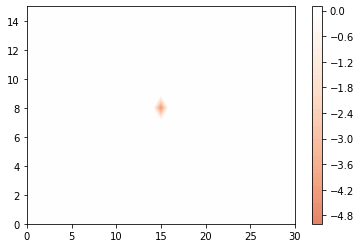

63


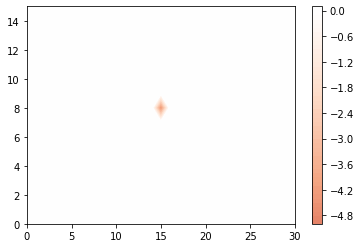

64


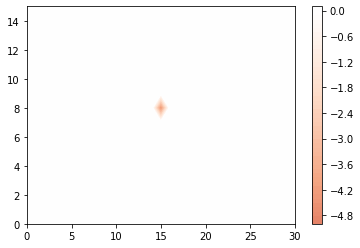

65


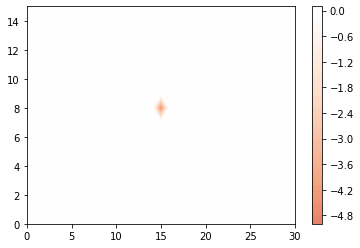

66


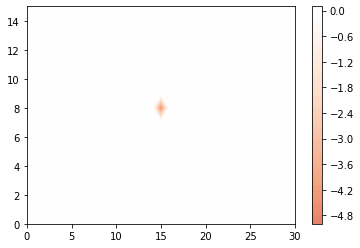

67


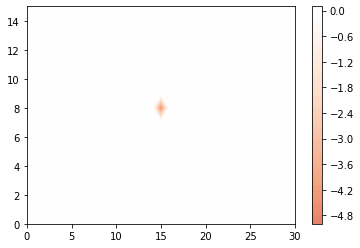

68


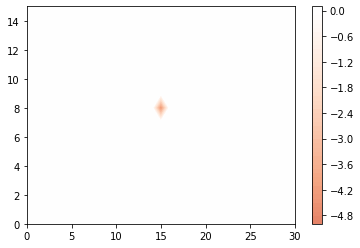

69


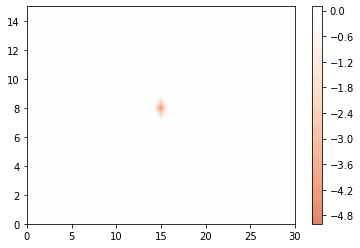

70


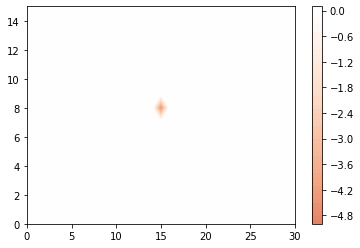

71


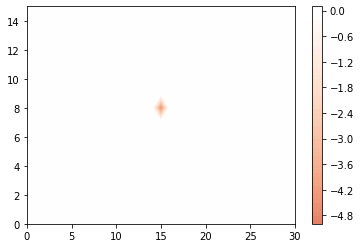

72


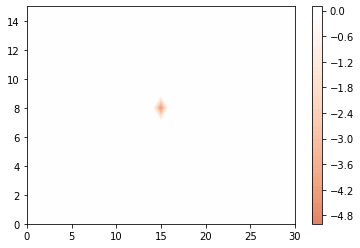

73


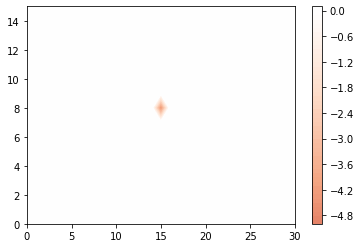

74


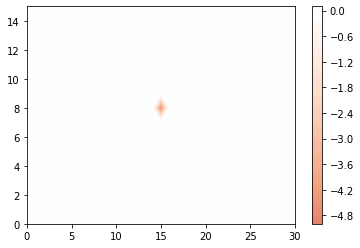

75


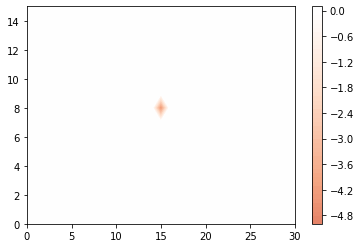

76


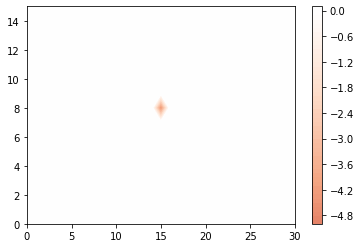

77


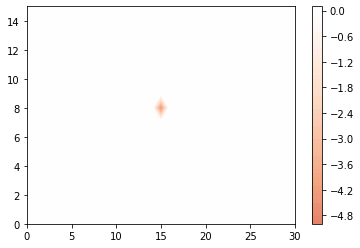

78


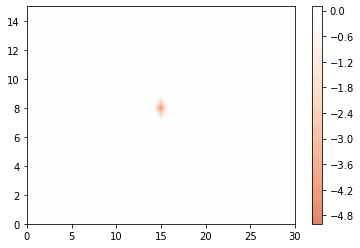

79


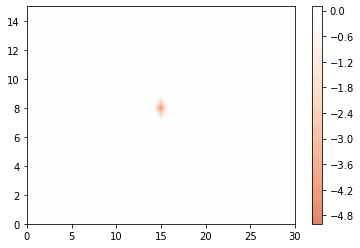

80


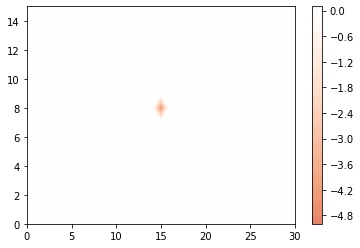

81


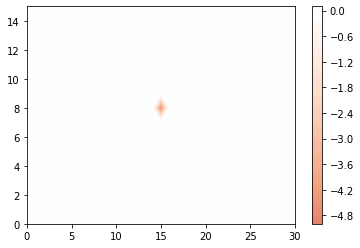

82


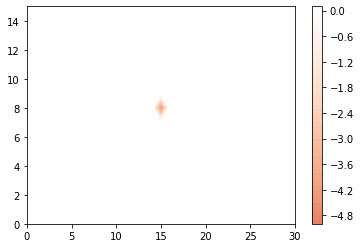

83


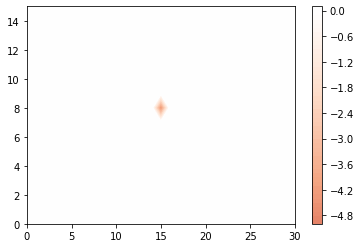

84


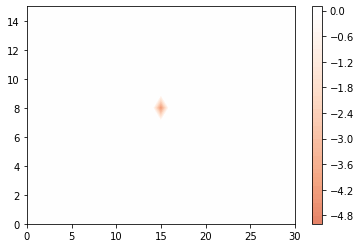

85


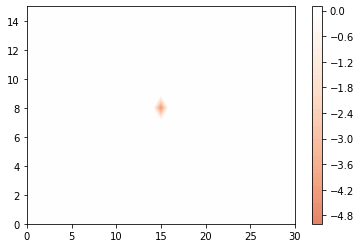

86


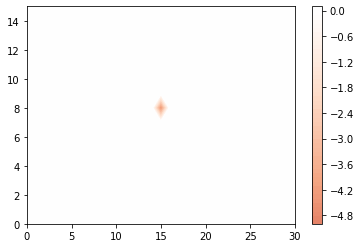

87


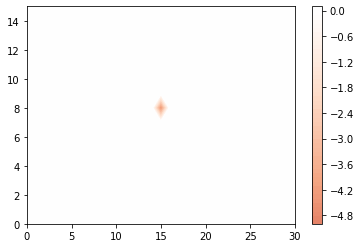

88


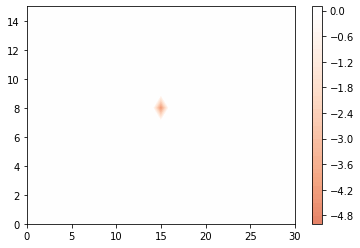

89


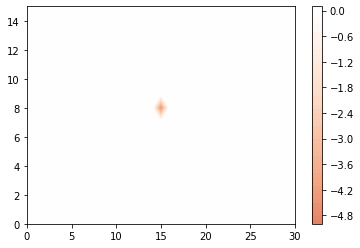

90


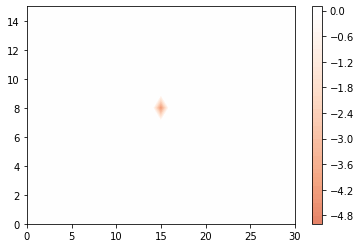

91


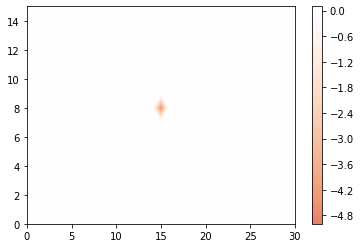

92


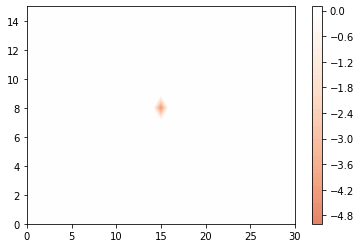

93


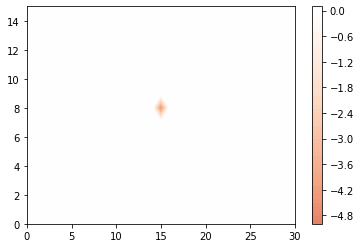

94


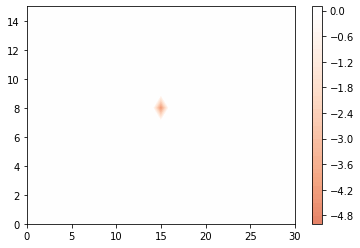

95


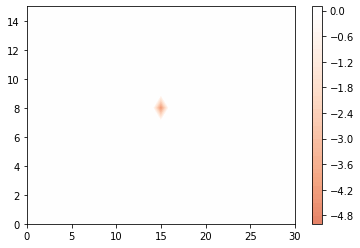

96


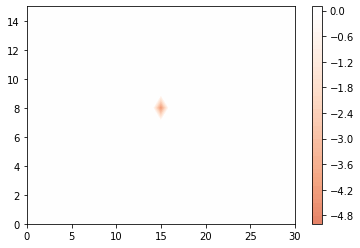

97


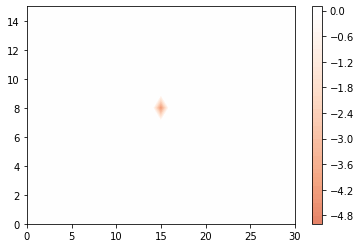

98


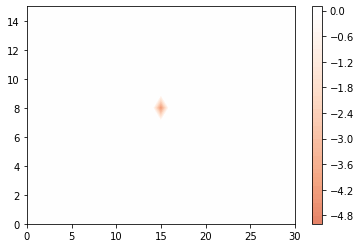

99


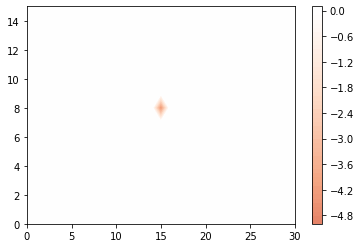

time: 4min 43s


In [ ]:
if __name__ == '__main__':

  tmax = 100

  Ondas = LatticeBoltzmann()
  #PInPoint, Ear = [[], []], [2, 9, 0]

  Final = []

  Ondas.Inicie(0,0,0,0)

  for t in range(tmax):
    Ondas.Collide(True)
    Ondas.Field(t)
    Ondas.Advection()
    
    print(t)
    Plot(Ondas, False)
    #Plot3D(Ondas)

    #Final.append(Ondas.ExportData('PInPointTest', t))
    #print(df)
    #PInPoint[0].append([t])
    #PInPoint[1].append([Ondas.Print(Ear)])

# Appendix

In [ ]:
import chainer
chainer.print_runtime_info()
!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.1.0" CUPY_VERSION="==5.1.0" sh -